#Evaluating the behavioural changes in the OpenAI cart pole task with a Full Microbial Genetic Algorithm

In this notebook, we will define a Full Microbial Genetic Algorithm to solve the cart pole task.

Firstly, we will define the cart pole task and how we manipulate it.

Secondly, we will define our FMGA model.

Thirdly, we will go through the experimentation of the different FMGA models (with varying hyper-parameters) to solve the cart pole task and their evaluation.

Note: Google Colab has crashed multiple times when generating the data here. This is why some of the plotted data here may differ from the equivalent graphs in the report.

##Packages and imports

In [ ]:
#Packages and imports

!apt-get update
!apt install xvfb 
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

import os
import shutil
import random
import copy
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import torch
import matplotlib.pyplot as plt
from statistics import mean
from prettytable import PrettyTable
from google.colab import files

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-upda

##Defining the OpenAI cart pole task

We first need to define the environment. Our environment is the cart pole environement, as that is the task we will be solving.

In [ ]:
#Defining the environment

env_name = 'CartPole-v1'
env = gym.make(env_name) #Create the gym environment
print(f"Action space {env.action_space} \nObservation space {env.observation_space}")

Action space Discrete(2) 
Observation space Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [ ]:
#Example of playing around with the environment
#Only random actions are used here

env_name = 'CartPole-v1'
env = gym.make(env_name)

env.reset()
done = False
while not done:
    action = env.action_space.sample() # put agent here
    obs, reward, done, info = env.step(action)
    print(f"obs{np.round(obs, 2)} reward {reward} action {action} done {done} info {info}")

obs[ 0.04 -0.24  0.    0.29] reward 1.0 action 0 done False info {}
obs[ 0.03 -0.44  0.01  0.58] reward 1.0 action 0 done False info {}
obs[ 0.02 -0.63  0.02  0.88] reward 1.0 action 0 done False info {}
obs[ 0.01 -0.44  0.04  0.59] reward 1.0 action 1 done False info {}
obs[ 0.   -0.63  0.05  0.89] reward 1.0 action 0 done False info {}
obs[-0.01 -0.44  0.07  0.62] reward 1.0 action 1 done False info {}
obs[-0.02 -0.63  0.08  0.93] reward 1.0 action 0 done False info {}
obs[-0.03 -0.83  0.1   1.25] reward 1.0 action 0 done False info {}
obs[-0.05 -0.64  0.12  0.99] reward 1.0 action 1 done False info {}
obs[-0.06 -0.83  0.14  1.32] reward 1.0 action 0 done False info {}
obs[-0.08 -0.64  0.17  1.07] reward 1.0 action 1 done False info {}
obs[-0.09 -0.84  0.19  1.41] reward 1.0 action 0 done False info {}
obs[-0.11 -0.65  0.22  1.18] reward 1.0 action 1 done True info {}


Each action we take on that cart pole in the environment creates the scene for the next episode. At each episode, the cart pole gives us information about its positioning in the environment, our agent decides on an action, the next episode starts. Here we define a function to run one episode, which will return a reward. The more reward the better.

In [ ]:
#Run an episode

def run_episode(env, agent):
  tot_reward = 0.0
  obs = env.reset()
  done = False
  while not done:
      action = agent.get_action(obs)
      obs, reward, done, info = env.step(action)
      tot_reward = tot_reward + reward
  return tot_reward

The cart pole, through its returned observations, can give us the metrics of how it is currently doing in the environment as we act on it with our agent. However, we can also visualise it. The following function can be used to visualise the episodes of the environemnt with an agent acting on it. We will not be using this function while learning. We will only be using that function for later qualitative examination of an agent.

27.0

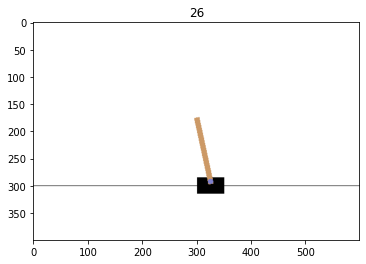

In [ ]:
#Visualise the episodes

def visual_episode(env, agent=None):
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)

    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward

        plt.imshow(screen)
        plt.title(curr_t)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        curr_t = curr_t + 1

    ipythondisplay.clear_output(wait=True)
    env.close()
    return tot_reward

# This is the function call
visual_episode(env)

Once we will have a good working agent that we want to save each episode of to show in a video, we will use the following function that saves every frame in a downloadable folder:

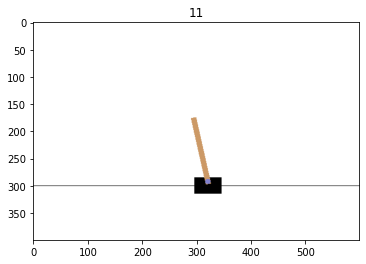

In [ ]:
#Save the frame of every episode to download later

def save_vis(env, agent=None, dirname='sim_frames'):
    if os.path.isdir(dirname):
      shutil.rmtree(dirname)
    os.makedirs(dirname, exist_ok=True)
    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward
        plt.imshow(screen)
        plt.title(curr_t)
        plt.savefig(os.path.join(dirname, 'fig{}'.format(curr_t)))
        curr_t += 1

# This is the function call
save_vis(env)

Now that we have successfully set our scene, we can define the Agent class that will be used to create the controllers. An agent will use a neural network to select its next action. We will encode the genes as the weights and biases of the neural networks. The agent, which we now know is a neural network, will use the observations given by the environment at each episode, and through its weights and biases defined by the genotypes it is set with, will decide on an action. The input is the 4 observations of the cart pole, the output is 1 action.

In [ ]:
#The Agent class, used to define an agent

class Agent:
    def __init__(self, num_input, num_output):
        self.num_input = num_input 
        self.num_output = num_output
        self.num_genes = num_input * num_output + num_output
        self.weights = None
        self.bias = None

    def set_genes(self, gene):
        weight_idxs = self.num_input * self.num_output
        bias_idxs = self.num_input * self.num_output + self.num_output
        w = gene[0 : weight_idxs].reshape(self.num_output, self.num_input)   
        b = gene[weight_idxs: bias_idxs].reshape(self.num_output,)
        self.weights = torch.from_numpy(w)
        self.bias = torch.from_numpy(b)

    def forward(self, x):
        x = torch.from_numpy(x).unsqueeze(0)
        return torch.mm(x, self.weights.T) + self.bias

    def get_action(self, x):
        if self.forward(x) > 0:
            return 1
        else:
            return 0

In [ ]:
#Example on how to define an agent

num_obs = 4 #The number of observations returned by the cart pole environment
num_actions = 1 #The number of actions it outputs
agent = Agent(num_obs, num_actions)

We now have an environment and an agent that can act upon it. We now need to define what will change our agent. This means we need to define the steps to making our agent learn. The agent will learn through keeping the environment run for as many epsiodes as it can. This means that to evaluate the fitness of one agent, we make it try and keep the cart pole up until it falls (the episode where it falls is its fitness), or until it reaches 500 episodes, which is the maximum fitness.

We sometimes need to evaluate the fitness of the entire population and sometimes of only one invidiual. We have made two separate functions to accomodate this need. This is not very pythonic but comes in useful to make the FMGA function (defined later on in this notebook) more readable.

In [ ]:
#Get the fitness of an entire population

def fitness_function(env, agent, gene_pop):
    # Get fitness for each gene
    pop_size = gene_pop.shape[0]
    pop_fitness = np.zeros(pop_size)
    for i, gene in enumerate(gene_pop):
        agent.set_genes(gene)
        pop_fitness[i] = run_episode(env, agent)
    return pop_fitness

In [ ]:
#Get the fitness of one individual (one genotype)

def fitness_function_individual(env, agent, gene):
    # Get fitness for one gene
    agent.set_genes(gene)
    fitness = run_episode(env, agent)
    return fitness

In our FMGA model (defined later on), we will be evaluating different genotypes and making changes to them. Once we have made changes, we need to decide if we are keeping them depending on if they improved the fitness of the population or decreased it. The following function performs this:

In [ ]:
#Take two populations and return the fittest one

def select_genes(prev_gene_pop, gene_pop, prev_fitness, fitness):
    new_gene_pop = np.zeros_like(gene_pop)
    for i, gene in enumerate(gene_pop): 
        if fitness[i] >= prev_fitness[i]: 
            new_gene_pop[i] = gene_pop[i]
        else:
            new_gene_pop[i] = prev_gene_pop[i]

    return new_gene_pop

##The FMGA model

In this section, we define our Full Microbial Genetic Algorithm. We will first go through the steps of how the model works, and then provide a function that does it all.

The first step is to define a population with random genotypes.

In [ ]:
#Printing a random population of 3 individuals with 4 genes each

population_size = 3
num_genes = 5
population = np.random.normal(0,0.1,(population_size,num_genes))
print(population)

[[-0.08307616  0.22491774 -0.02018263 -0.11830388  0.02429601]
 [-0.05892364 -0.10276805 -0.00136787 -0.01586228 -0.03726764]
 [-0.02713697  0.12153451 -0.0008488   0.19272863  0.02806755]]


The second step is to make the individuals go through tournaments. We have defined here how one torunament will play out. An FMGA model will play out many of these tournaments.

1 tournament == 1 epoch

In [ ]:
#Playing one tournament

# Create our agent
num_obs, num_actions = 4, 1 
agent = Agent(num_obs, num_actions)

#Get fitness of population before making any changes
original_fitness_population = fitness_function(env, agent, population)

#Picking a random individual
first_random_index = np.random.randint(len(population))
first_genotype = np.copy(population[first_random_index])

#Picking an individual in the first individual's neighbourhood
k = 2 #size of neighbourhood
second_random_index = first_random_index
while second_random_index == first_random_index: second_random_index = np.random.randint(low=first_random_index-(k/2), high=first_random_index+(k/2)+1) % len(population)
second_genotype = np.copy(population[second_random_index])

print("Individual 1's index:", first_random_index)
print("Individual 2's index:", second_random_index)
print('\n')

#Getting their fitness
first_genotype_fitness = original_fitness_population[first_random_index]
second_genotype_fitness = original_fitness_population[second_random_index]
print("Individual 1's fitness:", first_genotype_fitness)
print("Individual 2's fitness:", second_genotype_fitness)
print('\n')

#Getting a winner and a loser
winner_index = second_random_index if first_genotype_fitness < second_genotype_fitness else first_random_index
loser_index = first_random_index if first_genotype_fitness < second_genotype_fitness else second_random_index
print("Winner's index:", winner_index, '\n')

#Crossing over
crossover_probability = 0.5
loser_replacement = []
for j in range(len(population[loser_index])):
  if np.random.rand(1) <= crossover_probability:
    new_gene = np.copy(population[winner_index][j])
    loser_replacement.append(new_gene)
  else: loser_replacement.append(population[loser_index][j])
loser_replacement = np.array(loser_replacement)
print("Loser's original genotype:", population[loser_index])
print("Loser's replacement genotype:", loser_replacement, '\n')

#Getting old and new fitness
loser_original_fitness = fitness_function_individual(env, agent, population[loser_index])
loser_replacement_fitness = fitness_function_individual(env, agent, loser_replacement)
print("Loser's original fitness:", loser_original_fitness)
print("Loser's new fitness", loser_replacement_fitness)

#Checking if we're replacing the loser or not
replacement = False
if loser_original_fitness < loser_replacement_fitness:
  population[loser_index] = loser_replacement

#Printing the old and the new population's fitness
new_fitness_population = fitness_function(env, agent, population)
print('Replacement:', replacement)
print('Original fitness of population:',original_fitness_population)
print('New fitness of population:',new_fitness_population)

Individual 1's index: 0
Individual 2's index: 2


Individual 1's fitness: 58.0
Individual 2's fitness: 10.0


Winner's index: 0 

Loser's original genotype: [-0.02524167  0.02484622 -0.08842411  0.00543935  0.11559885]
Loser's replacement genotype: [-0.02524167  0.02484622 -0.08842411  0.1484635   0.11559885] 

Loser's original fitness: 9.0
Loser's new fitness 12.0
Replacement: False
Original fitness of population: [58. 10. 10.]
New fitness of population: [36. 10. 11.]


Here is the full function of the FMGA model. It takes two inputs: the number of epochs (tournaments) and the size of the population. Those are the modifiable hyper-parameters of our FMGA model that we will be trying to optimise. The output is the fitness of every individual in the population at each epoch.

In [ ]:
def FMGA(epochs=10, population_size=4):
  population_fitness_evolution = []

  # Create our agent
  num_obs, num_actions = 4, 1 
  agent = Agent(num_obs, num_actions)

  population = np.random.normal(0, 0.1, (population_size, num_genes))
  #print(fitness_function(env, agent, population))

  for i in range(epochs):
    if i % 50 == 0: print('epoch:',i)

    #Keep original population
    original_population = np.copy(population)
    original_fitness = np.copy(fitness_function(env, agent, original_population))

    #Picking a random individual
    first_random_index = np.random.randint(len(population))
    first_genotype = np.copy(population[first_random_index])

    #Picking an individual in the first individual's neighbourhood
    k = 2
    second_random_index = first_random_index
    while second_random_index == first_random_index: second_random_index = np.random.randint(low=first_random_index-(k/2), high=first_random_index+(k/2)+1) % len(population)
    second_genotype = np.copy(population[second_random_index])

    #Getting their fitness
    original_fitness_population = fitness_function(env, agent, population)
    first_genotype_fitness = original_fitness_population[first_random_index]
    second_genotype_fitness = original_fitness_population[second_random_index]

    #Getting a winner and a loser
    winner_index = second_random_index if first_genotype_fitness < second_genotype_fitness else first_random_index
    loser_index = first_random_index if first_genotype_fitness < second_genotype_fitness else second_random_index
    #Crossing over
    crossover_probability = 0.5
    loser_replacement = []
    for j in range(len(population[loser_index])):
      if np.random.rand(1) <= crossover_probability:
        new_gene = np.copy(population[winner_index][j])
        loser_replacement.append(new_gene)
      else: loser_replacement.append(population[loser_index][j])
    population[loser_index] = np.array(loser_replacement)

    #Choose if we're changing or not
    if fitness_function_individual(env, agent, population[loser_index]) < fitness_function_individual(env, agent, np.array(loser_replacement)):
      population[loser_index] = np.array(loser_replacement)

    #print(fitness_function(env, agent, population)) #to delete

    #Get the fitness of each genotype and add it to the population_fitness list
    population_fitness_evolution.append(fitness_function(env, agent, population))

  return population_fitness_evolution

## Experimentations on our models

Here is the outline of the experimentation we will be performing on our models:
1. Optimising the population size
2. Optimising the number of tournaments
3. Examining the observed behaviours of the best fit individual from our FMGA model at different epochs
4. Getting the visual frames of our best fit individual from our FMGA model at different epochs

###1. Optimising the population size

Optimising the population size is about finding which population size of our FMGA will have an individual that has the maximum fitness (500 episodes) first.

Due to the randomness of the initialiasition of the FMGA model's population, a large population will likely result in an initial individual already having the maximum fitness. This is not what we want as our later experimentations will be exploring how more tournaments lead to different agents, different behaviours. Furthermore, training a large population size is computationally expensive.

In [ ]:
#Plotting the average best fitness of FMGAs with different population sizes

#We define the different population sizes
pop_sizes = [i for i in range(2,53,10)]
print(pop_sizes)

#We make multiple models for each population sizes
average_fitness_per_tournament_per_pop_size = []
for pop_size in pop_sizes:
  print('Current pop size:',pop_size)
  average_fitness_per_tournament = []
  #Get fitness per tournament of 3 different models with the same population size
  for j in range(3):
    average_fitness_per_tournament.append([max(tournament) for tournament in FMGA(epochs=500,population_size=pop_size)])
  #Average out the fitness per tournament
  average_fitness_per_tournament = [mean([m1,m2,m3]) for m1,m2,m3 in zip(average_fitness_per_tournament[0],average_fitness_per_tournament[1],average_fitness_per_tournament[2])]
  average_fitness_per_tournament_per_pop_size.append(average_fitness_per_tournament)
  
#We plot the average best fitness of each population size over 100 epochs
for i in range(len(average_fitness_per_tournament_per_pop_size)):
  plt.plot(average_fitness_per_tournament_per_pop_size[i],label=str(pop_sizes[i]))
plt.axhline(y = 500, color = 'r', linestyle = 'dashed')   
plt.text(4, 473, 'max fitness', fontsize = 12)
plt.title('Average performance per tournament of\nFMGAs with different population sizes')
plt.ylabel('Fitness')
plt.xlabel('Tournament number')
plt.ylim([0,510])
plt.xlim([-2,500])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Population\nsize")
plt.show()

[2, 12, 22, 32, 42, 52]
Current pop size: 2


NameError: ignored

We find that a large population is more likely to have a best individual to have the maximum fitness. We also find that lower population seem to have spiky plateaus early on and never reach the maximum fitness. Therefore, we will chose a population size of 50 for the following experimentations in our FMGA model.

###2. Optimising the number of epochs

The aim of this section is to find how many epochs are needed to ensure that our FMGA model will have at least one individual with the maximum fitness of 500. This is useful to plot its evolution in behaviour later on, and to save some computational power.

We will train 3 models with a population size of 50 over 1000 epochs and plot the average best fitness at different epoch numbers. This will provide us with the data to determine the correct number of epochs to solve the cart pole task.

In [ ]:
#Plotting the average best fitness of an FMGA with a population size of 50 at every epoch

#Create and train 3 FMGAs with a population size of 50 for 1000 epochs
#Get their best fitness per tournament
models_best_fitnesses = []
for i in range(3):
  models_best_fitnesses.append([max(tournament) for tournament in FMGA(epochs=1000,population_size=50)])



epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450
epoch: 500
epoch: 550
epoch: 600
epoch: 650
epoch: 700
epoch: 750
epoch: 800
epoch: 850
epoch: 900
epoch: 950
epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450
epoch: 500
epoch: 550
epoch: 600
epoch: 650
epoch: 700
epoch: 750
epoch: 800
epoch: 850
epoch: 900
epoch: 950
epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450
epoch: 500
epoch: 550
epoch: 600
epoch: 650
epoch: 700
epoch: 750
epoch: 800
epoch: 850
epoch: 900
epoch: 950


In [ ]:
#Average out their best fitness at each tournament
avg_best_fit_per_tournament = [mean([m1,m2,m3]) for m1,m2,m3 in zip(models_best_fitnesses[0],models_best_fitnesses[1],models_best_fitnesses[2])]

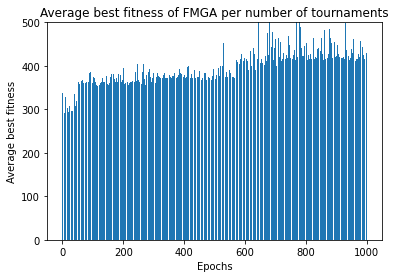

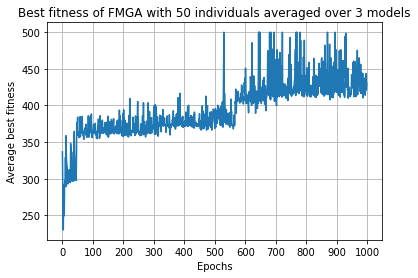

In [ ]:
#Make a bar plot that plots the average best fitness every 50 epochs
tournaments = [i for i in range(0,1000,25)]
#fig = plt.figure(figsize=(20, 10))
plt.title('Average best fitness of FMGA per number of tournaments')
plt.bar(height=avg_best_fit_per_tournament,x=[i for i in range(1000)])
#plt.xticks(tournaments) 
plt.xlabel('Epochs')
plt.ylabel('Average best fitness')
plt.ylim([0,500])
plt.show()

#Make a line plot that plots the average best fitness at every epoch
plt.plot(avg_best_fit_per_tournament)
plt.title('Best fitness of FMGA with 50 individuals averaged over 3 models')
plt.xlabel('Epochs')
plt.ylabel('Average best fitness')
plt.xticks([i for i in range(0,1100,100)])
plt.grid()
plt.show()

We notice that after XXX number of epochs, we reach an average maximum fitness of 500. Therefore, there shouldn't be a need to train over more than XXX epochs if we are only looking for a genotype that can keep the pole up for 500 episodes.

We hypothesise that more epochs will lead to more robust individuals. This can be found by exploring the behaviour of the individuals through their observations.

###3. Examining observed behaviours (quantitative exploration)

In this section, we examine the obserevd behaviours of our optimised FMGA model's best individuals at different numbers of epochs. This means that we will train an FMGA for a certain number of epochs, get its best individual, and plot its observed behaviours. We will then compare the best individuals' plotted behaviours at different numbers of epochs to see if there are differences.

It is important to remember in this section that we are only plotting metrical observational values, not the actual scenery visualisation. This is kept for our qualitative examination.

We will first collect the genotypes of the best individual at each epoch.

To do so, we need to create and train an FMGA and make it return the best genotype (the one with the best fitness) at each epoch.

In [ ]:
#Function that creates an FMGA model and returns the most fit individual's genotype at each epoch

def FMGA_best_gene(epochs=10, population_size=4):
  best_genotype_per_epoch = []

  # Create our agent
  num_obs, num_actions = 4, 1 
  agent = Agent(num_obs, num_actions)

  population = np.random.normal(0, 0.1, (population_size, num_genes))
  #print(fitness_function(env, agent, population))

  for i in range(epochs):
    if i % 50 == 0: print('epoch:',i)

    #Keep original population
    original_population = np.copy(population)
    original_fitness = np.copy(fitness_function(env, agent, original_population))

    #Picking a random individual
    first_random_index = np.random.randint(len(population))
    first_genotype = np.copy(population[first_random_index])

    #Picking an individual in the first individual's neighbourhood
    k = 2
    second_random_index = first_random_index
    while second_random_index == first_random_index: second_random_index = np.random.randint(low=first_random_index-(k/2), high=first_random_index+(k/2)+1) % len(population)
    second_genotype = np.copy(population[second_random_index])

    #Getting their fitness
    original_fitness_population = fitness_function(env, agent, population)
    first_genotype_fitness = original_fitness_population[first_random_index]
    second_genotype_fitness = original_fitness_population[second_random_index]

    #Getting a winner and a loser
    winner_index = second_random_index if first_genotype_fitness < second_genotype_fitness else first_random_index
    loser_index = first_random_index if first_genotype_fitness < second_genotype_fitness else second_random_index
    #Crossing over
    crossover_probability = 0.5
    loser_replacement = []
    for j in range(len(population[loser_index])):
      if np.random.rand(1) <= crossover_probability:
        new_gene = np.copy(population[winner_index][j])
        loser_replacement.append(new_gene)
      else: loser_replacement.append(population[loser_index][j])
    population[loser_index] = np.array(loser_replacement)

    #Choose if we're changing or not
    if fitness_function_individual(env, agent, population[loser_index]) < fitness_function_individual(env, agent, np.array(loser_replacement)):
      population[loser_index] = np.array(loser_replacement)

    #Get the fitness of each individual in the population, store the genotype with the highest fitness
    population_fitnesses = fitness_function(env, agent, population)
    index_best_genotype = max(range(len(population_fitnesses)), key=population_fitnesses.__getitem__)
    best_genotype_per_epoch.append(population[index_best_genotype])

  return best_genotype_per_epoch

In [ ]:
#Create and train an FMGA model of population size 50 for 1000 epochs with the function defined above
best_genotypes = FMGA_best_gene(epochs=1000, population_size=50)
print('Best genotype at epoch 2:',best_genotypes[2])

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450
epoch: 500
epoch: 550
epoch: 600
epoch: 650
epoch: 700
epoch: 750
epoch: 800
epoch: 850
epoch: 900
epoch: 950
Best genotype at epoch 2: [ 0.0089485   0.08519416  0.09250396  0.06365342 -0.00529261]


Now we can observe the behaviours of the best genotypes of our model at different numbers of epochs. To do so, we will create a function that plots the 4 observations.

In [ ]:
#Function that takes a genotype and plots its observed behaviours over the episodes
#Input: genotype for cart pole agent

def observe_behaviour(genotype):
  #Get the environment
  env_name = 'CartPole-v1'
  env = gym.make(env_name)

  #Make the agent
  num_obs, num_actions = 4, 1 
  agent = Agent(num_obs, num_actions)
  agent.set_genes(genotype)

  #Record the observations over the episodes
  obs = env.reset()
  done = False
  recorded_obsverations = []
  while not done:
      action = agent.get_action(obs)
      obs, reward, done, info = env.step(action)
      recorded_obsverations.append(np.round(obs, 2))

  #Plot the position of the cart
  position_of_cart = [observations[0] for observations in recorded_obsverations]
  plt.plot(position_of_cart)
  plt.xlabel('Number of episodes')
  plt.ylabel('Position of cart')
  plt.title('Position of cart over episodes')
  plt.xlim([0,500])
  plt.grid()
  plt.show()

  #Plot the velocity of the cart
  velocity_of_cart = [observations[1] for observations in recorded_obsverations]
  plt.plot(velocity_of_cart, color='green')
  plt.xlabel('Number of episodes')
  plt.ylabel('Velocity of cart')
  plt.title('Velocity of cart over episodes')
  plt.xlim([0,500])
  plt.grid()
  plt.show()

  #Plot the angle of the pole
  angle_of_pole = [observations[2] for observations in recorded_obsverations]
  plt.plot(angle_of_pole, color='red')
  plt.xlabel('Number of episodes')
  plt.ylabel('Angle of pole on cart')
  plt.title('Angle of pole over episodes')
  plt.xlim([0,500])
  plt.grid()
  plt.show()

  #Plot the rotation rate of the pole
  rotation_rate_of_pole = [observations[3] for observations in recorded_obsverations]
  plt.plot(rotation_rate_of_pole, color='orange')
  plt.xlabel('Number of episodes')
  plt.ylabel('Rotation rate of pole')
  plt.title('Rotation rate of pole over episodes')
  plt.xlim([0,500])
  plt.grid()
  plt.show()

In [ ]:
#Plot the observed behaviours of the best genotype at epoch 0
observe_behaviour(best_genotypes[0])

In [ ]:
#Plot the observed behaviours of the best genotype at epoch 250
observe_behaviour(best_genotypes[250])

In [ ]:
#Plot the observed behaviours of the best genotype at epoch 500
observe_behaviour(best_genotypes[500])

In [ ]:
#Plot the observed behaviours of the best genotype at epoch 750
observe_behaviour(best_genotypes[750])

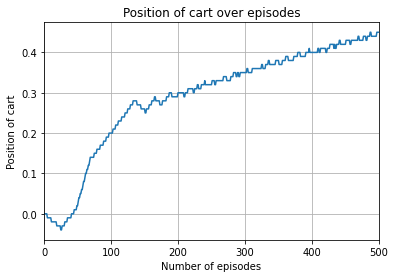

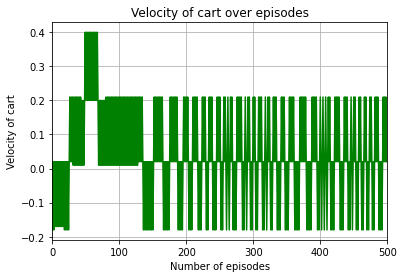

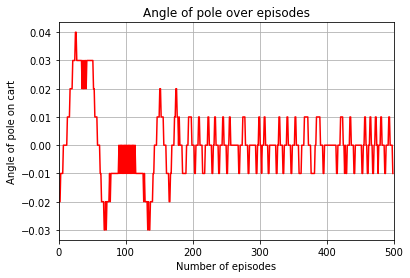

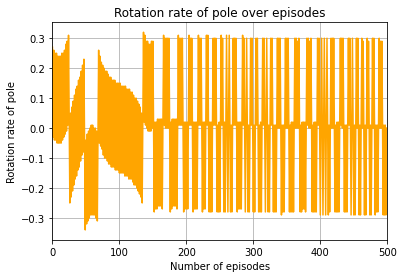

In [ ]:
#Plot the observed behaviours of the best genotype at epoch 1000
observe_behaviour(best_genotypes[999])

###4. Getting the visual frames (qualitative exploration)

A quantitative exploration reveals a lot about how our agent behaves, but observing it visually may reveal something we cannot see in the numbers. We will take each frame from an agent's actions on the cart pole environment, and download them to put them into one video. In this notebook, we need to get the genotype we want to visually observe, and use the save_vis function (defined in the beginning) that exports its frames. 

We will put these frames together to make a video (one video per genotype) and upload it to YouTube.

Link to playlist of videos: https://www.youtube.com/watch?v=9kkyeyACH_Q&list=PLG2p0BQ1eHPP5ZPDcx3zI80jUHque9SaI&index=3&ab_channel=ArthurMonSoss

Getting the frames for the agent made with best genotype at epoch 0.

In [ ]:
agent = Agent(4, 1)

In [ ]:
agent.set_genes(best_genotypes[0])

In [ ]:
save_vis(env,agent,dirname='sim_frames_epoch_0_test')

In [ ]:
from google.colab import files
!zip -r /content/sim_frames_epoch_0_test.zip /content/sim_frames_epoch_0_test
files.download("/content/sim_frames_epoch_0_test.zip")

Getting the frames for the agent made with best genotype at epoch 500.

In [ ]:
agent = Agent(4, 1)

In [ ]:
agent.set_genes(best_genotypes[500])

In [ ]:
save_vis(env,agent,dirname='sim_frames_epoch_500_test')

In [ ]:
!zip -r /content/sim_frames_epoch_500_test.zip /content/sim_frames_epoch_500_test
files.download("/content/sim_frames_epoch_500_test.zip")

Getting the frames for the agent made with best genotype at epoch 1000.

In [ ]:
agent = Agent(4, 1)

In [ ]:
agent.set_genes(best_genotypes[999])

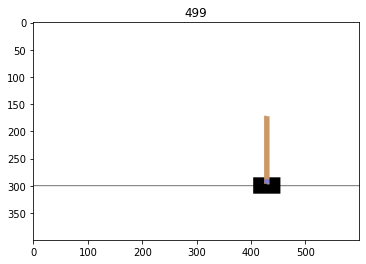

In [ ]:
save_vis(env,agent,dirname='sim_frames_epoch_1000_test')

In [ ]:
!zip -r /content/sim_frames_epoch_1000_test.zip /content/sim_frames_epoch_1000_test
files.download("/content/sim_frames_epoch_1000_test.zip")

updating: content/sim_frames_epoch_1000_test/ (stored 0%)
updating: content/sim_frames_epoch_1000_test/fig375.png (deflated 17%)
updating: content/sim_frames_epoch_1000_test/fig77.png (deflated 16%)
updating: content/sim_frames_epoch_1000_test/fig126.png (deflated 16%)
updating: content/sim_frames_epoch_1000_test/fig312.png (deflated 18%)
updating: content/sim_frames_epoch_1000_test/fig170.png (deflated 17%)
updating: content/sim_frames_epoch_1000_test/fig57.png (deflated 17%)
updating: content/sim_frames_epoch_1000_test/fig16.png (deflated 17%)
updating: content/sim_frames_epoch_1000_test/fig493.png (deflated 18%)
updating: content/sim_frames_epoch_1000_test/fig485.png (deflated 16%)
updating: content/sim_frames_epoch_1000_test/fig499.png (deflated 17%)
updating: content/sim_frames_epoch_1000_test/fig64.png (deflated 17%)
updating: content/sim_frames_epoch_1000_test/fig405.png (deflated 17%)
updating: content/sim_frames_epoch_1000_test/fig98.png (deflated 17%)
updating: content/sim_fr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>